# TP2 : Charlie et la chocolaterie

Aujourd'hui, place à la pratique ! Au programme, des acquistions, de la calibration, de la détection et de la mesure... de bonbons... L'objectif : créer une chaîne de traitement "simplifiée" permettant de détecter et mesurer des bonbons. Et oui, même les bonbons ont besoin de contrôle qualité !

*Note : Le TP est très chargé, mais c'est pour vous donner un exemple concret d'application. Bien évidemment, je noterai en conséquences, donc donnez le max et tout ira bien :D*

---
## 1) Acquisition

Avant de coder, il faut avoir des images ! Pour cela, vous avez à votre disposition une caméra qui devra être fixe. Pour la calibration, vous avez un échiquier, qu'il faudra bouger/incliner entre chaque captation. Placez votre caméra bien perpendiculairement au plan de travail, afin d'avoir des images de bonne qualité. 

Prenez bien le temps de faire des bonnes acquisitions. On peut corriger les images en post-traitement, mais si l'acquisition est mauvaise, on ne peut pas faire des miracles non plus !

Pour le TP, il vous faudra :
- Une dizaine d'images avec l'échiquier pour effectuer la calibration (Attention : il faut qu'on puisse voir ENTIEREMENT l'échiquier sur l'image !)
- Une image contenant uniquement une ou plusieurs pièces de monnaie
- Quelques images contenant des bonbons. Variez le nombre, les couleurs, la qualité (ex : bonbon coupé en deux), ainsi que leurs orientations.

Dès que toutes les acquisitions sont faites, affichez-les toutes ci-dessous:

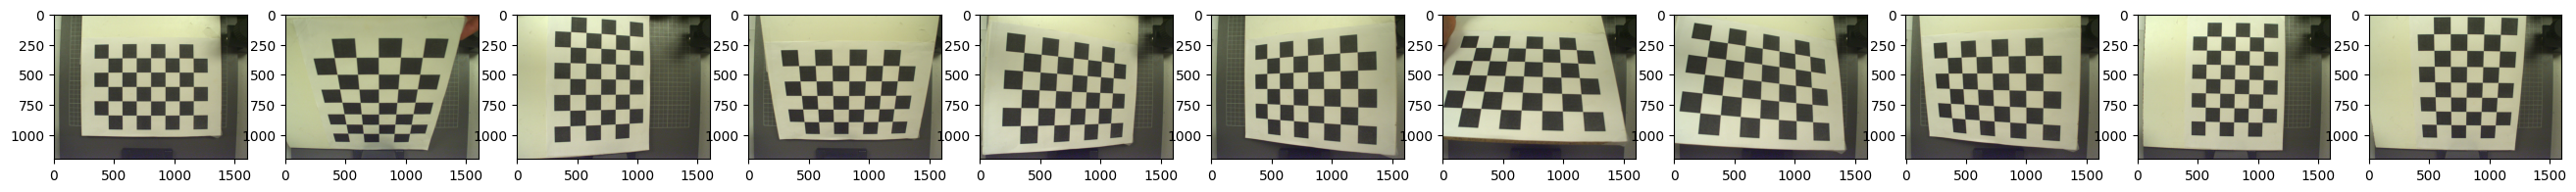

In [1]:
# A compléter
# Chargement des librairies usuelles
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

# Chargement des images pour la calibration
path = 'images_calibration_31_05_2024/captureDetQ/'
path_calibration=path+'calibration/'
files = os.listdir(path_calibration)
images_calibration = [cv2.cvtColor(cv2.imread(path_calibration+f,1),cv2.COLOR_BGR2RGB) for f in files]

# Affichage des images pour la calibration
plt.figure(figsize=(len(images_calibration)*3,5))
for i,img in enumerate(images_calibration):
    plt.subplot(1,len(images_calibration),i+1)
    plt.imshow(img)
plt.show()

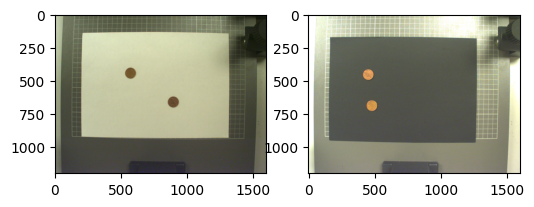

In [2]:
# Chargement de l'image contenant la pièce de monnaie
path_pieces = path+'pieces/'
files = os.listdir(path_pieces)
images_pieces = [cv2.cvtColor(cv2.imread(path_pieces+f,1),cv2.COLOR_BGR2RGB) for f in files]

# Affichage de l'image avec la pièce de monnaie
plt.figure(figsize=(len(images_pieces)*3,5))
for i,img in enumerate(images_pieces):
    plt.subplot(1,len(images_pieces),i+1)
    plt.imshow(img)
plt.show()

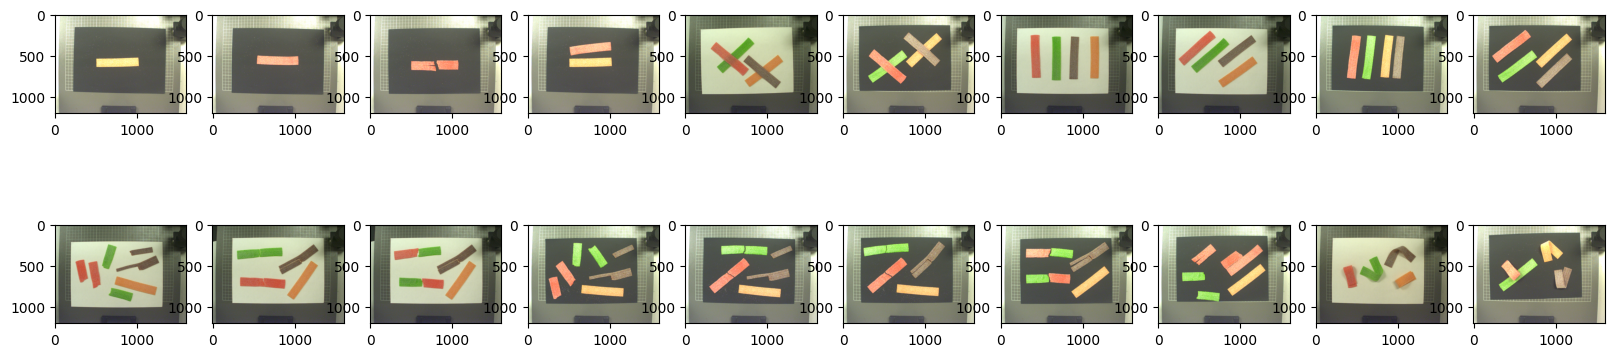

In [3]:
# Chargement des images contenant les bonbons
path_bonbons = path+'bonbons/'
files = os.listdir(path_bonbons)
images_bonbons = [cv2.cvtColor(cv2.imread(path_bonbons+f,1),cv2.COLOR_BGR2RGB) for f in files]

# Affichage des images avec les bonbons
plt.figure(figsize=(len(images_bonbons),5))
for i,img in enumerate(images_bonbons):
    plt.subplot(2,len(images_bonbons)//2,i+1)
    plt.imshow(img)
plt.show()

---
## 2) Calibration

Avant de faire la moindre détection, on va d'abord estimer les paramètres de calibration de la caméra. Cela permettra ensuite de corriger les images. Attention, utilisez bien uniquement les images acquises pour la calibration (donc celles contenant un échiquier). Pour cela, écrivez une fonction prenant en entrée les images prévues pour la calibration et retournant les résultats de calibrations.

A la fin de l'étape, affichez :
- Les paramètres intrinsèques de la caméra (en expliquant ce que signifient les valeurs obtenues)
- Les paramètres extrinsèques sur 2 images (en expliquant ce que signifient les valeurs obtenues)
- Les coefficients de distorsion calculés (en distinguant les types de coefficients)
- L'erreur de re-projection moyenne (vérifiant si la calibration est viable)

Et n'hésitez pas à montrer les résultats de la calibration avec une figure 3D, avec la caméra et la position des échiquiers des différentes images estimées. Bon courage !

*PS :* **Commentez impérativement le code !**

In [4]:
# A compléter
# Fonction d'estimation des paramètres de calibration de la caméra
def calibrateCamera(images, dim_grid, square_size):
    objp = np.zeros((dim_grid[0]*dim_grid[1],3), np.float32)
    objp[:,:2] = np.mgrid[0:dim_grid[0],0:dim_grid[1]].T.reshape(-1,2) * square_size

    objpoints = [] 
    imgpoints = [] 

    for img in images:
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, dim_grid, None)
        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)
            corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
            imgpoints.append(corners2)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, 4, None, None, cv2.CALIB_ZERO_TANGENT_DIST)

    mean_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
        mean_error += error
    
    return mtx, dist, rvecs, tvecs, mean_error/len(objpoints)

# Estimation des paramètres sur les images acquises pour la calibration
dim_grid = (7,5)
square_size = 30

mtx, dist, rvecs, tvecs, mean_error = calibrateCamera(images_calibration,dim_grid, square_size)

In [5]:
# Affichage des paramètres intrinsèques de la caméra
print("Paramètres intrinsèques : \n{}".format(mtx))

Paramètres intrinsèques : 
[[1.79181611e+03 0.00000000e+00 7.72120724e+02]
 [0.00000000e+00 1.79215475e+03 5.90772235e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]



***Signification des paramètres intrinsèques :***

In [6]:
# Affichage des paramètres extrinsèques sur 2 images
print("Paramètres extrinsèques sur la première image :")
print("Rotation : \n{}".format(cv2.Rodrigues(rvecs[0])[0]))
print("Translation : \n{}".format(tvecs[0]))
print("\nParamètres extrinsèques sur la deuxième image :")
print("Rotation : \n{}".format(cv2.Rodrigues(rvecs[1])[0]))
print("Translation : \n{}".format(tvecs[1]))

Paramètres extrinsèques sur la première image :
Rotation : 
[[ 9.99951038e-01  4.15219809e-04  9.88680307e-03]
 [-4.56328303e-04  9.99991260e-01  4.15602302e-03]
 [-9.88499099e-03 -4.16033117e-03  9.99942488e-01]]
Translation : 
[[-81.88994423]
 [-56.22404319]
 [451.25911151]]

Paramètres extrinsèques sur la deuxième image :
Rotation : 
[[ 4.51022813e-03 -9.99982833e-01  3.74056261e-03]
 [ 7.30584229e-01  7.40975126e-04 -6.82822184e-01]
 [ 6.82807691e-01  5.81247988e-03  7.30575029e-01]]
Translation : 
[[ 60.15129974]
 [-37.10405811]
 [289.79177204]]



***Signification des paramètres extrinisèques :***

In [7]:
# Affichage des coefficients de distorsion
print("Coefficients de distorsion : \n{}".format(dist))

Coefficients de distorsion : 
[[-0.32234765]
 [ 1.12431993]
 [ 0.        ]
 [ 0.        ]
 [-3.60375409]]



***Détail des coefficients de distorsion :***

In [8]:
# Calcul de l'erreur de re-projection moyenne
print("Erreur de re-projection moyenne : {}".format(mean_error))

Erreur de re-projection moyenne : 0.07589981619592608


***Explication de l'erreur de re-projection moyenne et analyse sur votre calibration :***

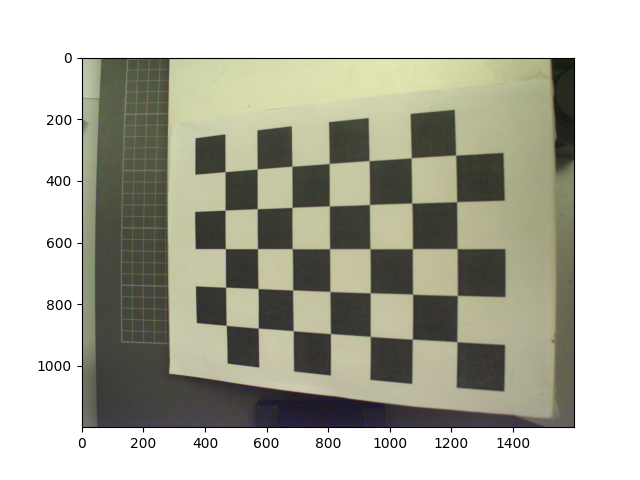

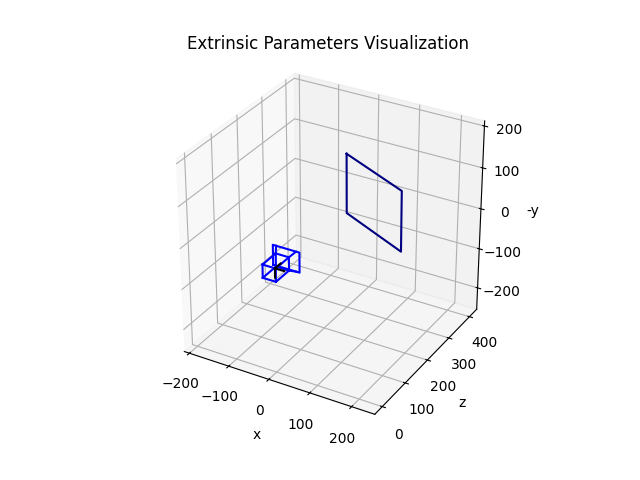

In [35]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib widget

# Plein de fonctions pour l'affichage 3D des résultats de la calibration

def inverse_homogeneoux_matrix(M):
    R = M[0:3, 0:3]
    T = M[0:3, 3]
    M_inv = np.identity(4)
    M_inv[0:3, 0:3] = R.T
    M_inv[0:3, 3] = -(R.T).dot(T)

    return M_inv

def transform_to_matplotlib_frame(cMo, X, inverse=False):
    M = np.identity(4)
    M[1,1] = 0
    M[1,2] = 1
    M[2,1] = -1
    M[2,2] = 0

    if inverse:
        return M.dot(inverse_homogeneoux_matrix(cMo).dot(X))
    else:
        return M.dot(cMo.dot(X))

def create_camera_model(camera_matrix, width, height, scale_focal, draw_frame_axis=False):
    fx = camera_matrix[0,0]
    fy = camera_matrix[1,1]
    focal = 2 / (fx + fy)
    f_scale = scale_focal * focal

    # draw image plane
    X_img_plane = np.ones((4,5))
    X_img_plane[0:3,0] = [-width, height, f_scale]
    X_img_plane[0:3,1] = [width, height, f_scale]
    X_img_plane[0:3,2] = [width, -height, f_scale]
    X_img_plane[0:3,3] = [-width, -height, f_scale]
    X_img_plane[0:3,4] = [-width, height, f_scale]

    ratio1 = 0.66
    ratio2 = 0.66
    width=height
    min_cam = -f_scale/2

    # draw camera
    X_center1 = np.array([[-width*ratio1, -width],
                          [height*ratio1, height],
                          [f_scale*ratio2, f_scale],
                          [1, 1]])

    X_center2 = np.array([[width*ratio1, width],
                          [height*ratio1, height],
                          [f_scale*ratio2, f_scale],
                          [1, 1]])

    X_center3 = np.array([[width*ratio1, width],
                          [-height*ratio1, -height],
                          [f_scale*ratio2, f_scale],
                          [1, 1]])

    X_center4 = np.array([[-width*ratio1, -width],
                          [-height*ratio1, -height],
                          [f_scale*ratio2, f_scale],
                          [1, 1]])

    X_center5 = np.stack([X_center1[:,0],X_center2[:,0]],axis=-1)
    X_center6 = np.stack([X_center2[:,0],X_center3[:,0]],axis=-1)
    X_center7 = np.stack([X_center3[:,0],X_center4[:,0]],axis=-1)
    X_center8 = np.stack([X_center4[:,0],X_center1[:,0]],axis=-1)

    X_center9 = np.stack([X_center5[:,0],X_center5[:,0]],axis=-1)
    X_center9[2,1] = min_cam
    X_center10 = np.stack([X_center6[:,0],X_center6[:,0]],axis=-1)
    X_center10[2,1] = min_cam 
    X_center11 = np.stack([X_center7[:,0],X_center7[:,0]],axis=-1)
    X_center11[2,1] = min_cam
    X_center12 = np.stack([X_center8[:,0],X_center8[:,0]],axis=-1)
    X_center12[2,1] = min_cam

    X_center13 = X_center5.copy()
    X_center13[2,:] = min_cam
    X_center14 = X_center6.copy()
    X_center14[2,:] = min_cam
    X_center15 = X_center7.copy()
    X_center15[2,:] = min_cam
    X_center16 = X_center8.copy()
    X_center16[2,:] = min_cam

    # draw camera frame axis
    X_frame1 = np.ones((4,2))
    X_frame1[0:3,0] = [0, 0, 0]
    X_frame1[0:3,1] = [f_scale/2, 0, 0]

    X_frame2 = np.ones((4,2))
    X_frame2[0:3,0] = [0, 0, 0]
    X_frame2[0:3,1] = [0, f_scale/2, 0]

    X_frame3 = np.ones((4,2))
    X_frame3[0:3,0] = [0, 0, 0]
    X_frame3[0:3,1] = [0, 0, f_scale/2]

    if draw_frame_axis:
        return [X_img_plane, X_center1, X_center2, X_center3, X_center4,
                X_center5, X_center6, X_center7, X_center8,
                X_center9, X_center10, X_center11, X_center12,
                X_center13, X_center14, X_center15, X_center16, 
                X_frame1, X_frame2, X_frame3]
    else:
        return [X_img_plane, X_center1, X_center2, X_center3, X_center4,
                X_center5, X_center6, X_center7, X_center8,
                X_center9, X_center10, X_center11, X_center12]

def create_board_model(board_width, board_height, square_size, draw_frame_axis=False):
    width = board_width*square_size
    height = board_height*square_size

    # draw calibration board
    X_board = np.ones((4,5))
    #X_board_cam = np.ones((extrinsics.shape[0],4,5))
    X_board[0:3,0] = [0,0,0]
    X_board[0:3,1] = [width,0,0]
    X_board[0:3,2] = [width,height,0]
    X_board[0:3,3] = [0,height,0]
    X_board[0:3,4] = [0,0,0]

    # draw board frame axis
    X_frame1 = np.ones((4,2))
    X_frame1[0:3,0] = [0, 0, 0]
    X_frame1[0:3,1] = [height/2, 0, 0]

    X_frame2 = np.ones((4,2))
    X_frame2[0:3,0] = [0, 0, 0]
    X_frame2[0:3,1] = [0, height/2, 0]

    X_frame3 = np.ones((4,2))
    X_frame3[0:3,0] = [0, 0, 0]
    X_frame3[0:3,1] = [0, 0, height/2]

    if draw_frame_axis:
        return [X_board, X_frame1, X_frame2, X_frame3]
    else:
        return [X_board]

def draw_camera_boards(ax, camera_matrix, cam_width, cam_height, scale_focal,
                       extrinsics, board_width, board_height, square_size,
                       patternCentric):
    min_values = np.zeros((3,1))
    min_values = np.inf
    max_values = np.zeros((3,1))
    max_values = -np.inf

    if patternCentric:
        X_moving = create_camera_model(camera_matrix, cam_width, cam_height, scale_focal)
        X_static = create_board_model(board_width, board_height, square_size)
        static_colors = ['b' for i in range(len(X_static))]
    else:
        X_static = create_camera_model(camera_matrix, cam_width, cam_height, scale_focal, True)
        X_moving = create_board_model(board_width, board_height, square_size)
        static_colors = ['b' for i in range(len(X_static))]
        static_colors[-3]='k'
        static_colors[-2]='k'
        static_colors[-1]='k'
    cm_subsection = np.linspace(0.0, 1.0, extrinsics.shape[0])
    colors = [ cm.jet(x) for x in cm_subsection]

    
    for i in range(len(X_static)):
        X = np.zeros(X_static[i].shape)
        for j in range(X_static[i].shape[1]):
            X[:,j] = transform_to_matplotlib_frame(np.eye(4), X_static[i][:,j])
        ax.plot3D(X[0,:], X[1,:], X[2,:], color=static_colors[i])
        min_values = np.minimum(min_values, X[0:3,:].min(1))
        max_values = np.maximum(max_values, X[0:3,:].max(1))

    for idx in range(extrinsics.shape[0]):
        R, _ = cv2.Rodrigues(extrinsics[idx,0:3])
        cMo = np.eye(4,4)
        cMo[0:3,0:3] = R
        cMo[0:3,3] = extrinsics[idx,3:6]
        for i in range(len(X_moving)):
            X = np.zeros(X_moving[i].shape)
            for j in range(X_moving[i].shape[1]):
                X[0:4,j] = transform_to_matplotlib_frame(cMo, X_moving[i][0:4,j], patternCentric)
            ax.plot3D(X[0,:], X[1,:], X[2,:], color=colors[idx])
            min_values = np.minimum(min_values, X[0:3,:].min(1))
            max_values = np.maximum(max_values, X[0:3,:].max(1))

    return min_values, max_values

def calibration_figure(dim_grid, # Dimensions de la grille (tuple (h,w))
                       square_size, # Taille des carreaux (en mm)
                       intrinsics, # Matrice des paramètres intrinsèques, de taille 3x3
                       rotations, # Liste des matrices de rotations de taille (3,1). La liste est de taille N (nombre d'images/échiquiers à afficher).
                       translations, # Liste des matrices de translations de taille (3,1). La liste est de taille N (nombre d'images/échiquiers à afficher).
                       indices_boards=None):
    
    board_width,board_height=dim_grid
    extrinsics = np.stack([np.concatenate([a[:,0],b[:,0]]) for a,b in zip(rotations,translations)],axis=-1).T

    if indices_boards is not None:
        extrinsics = extrinsics[indices_boards]

    fig = plt.figure()
    ax = fig.add_subplot(projection = '3d')
    ax.set_aspect("equal")

    cam_width = 32 
    cam_height = 24 
    scale_focal = 80000
    min_values, max_values = draw_camera_boards(ax, intrinsics, cam_width, cam_height,
                                                scale_focal, extrinsics, board_width,
                                                board_height, square_size, False)

    X_min,Y_min,Z_min = min_values
    X_max,Y_max,Z_max = max_values
    max_range = np.array([X_max-X_min, Y_max-Y_min, Z_max-Z_min]).max() / 2.0

    mid_x = (X_max+X_min) * 0.5
    mid_y = (Y_max+Y_min) * 0.5
    mid_z = (Z_max+Z_min) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('-y')
    ax.set_title('Extrinsic Parameters Visualization')
    plt.show()

id=5

plt.figure()
plt.imshow(images_calibration[id])
plt.show()
calibration_figure(dim_grid,square_size,mtx,rvecs,tvecs,indices_boards=[id])

Comparez les résultats de calibration obtenus avec les paramètres disponibles dans la fiche technique de la caméra (sur Moodle). Retrouvez-vous les valeurs dans votre estimation ?

***Réponse :***

---
## 3) Correction des images

Après votre calibration effectuée, il faut maintenant corriger la distorsion des images. Développez une fonction de correction d'image, prenant en entrée une image et les paramètres de calibration de la caméra, et retournant l'image corrigée. Appliquez une correction à partir des résultats précédents sur vos images tests (images non utilisées pour la calibration). Affichez-les images corrigées et comparez par rapport avec les images non corrigées (2-3 exemples max, pas besoin de tout m'afficher).

Comme précédemment, **commentez votre code !**

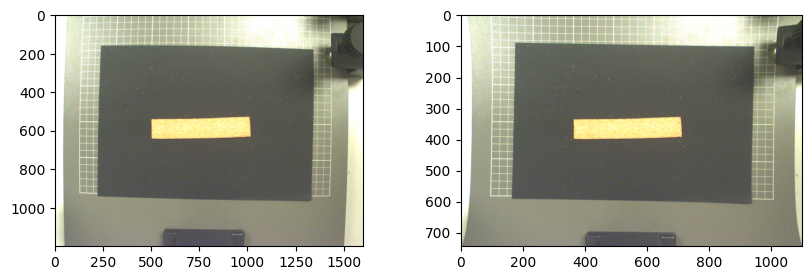

In [9]:
%matplotlib inline

# A compléter
# Fonction de correction de la distorsion d'une image ou plusieurs images
def imageCorrection(img, mtx, dist):
    h,  w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
    corrected_img = cv2.undistort(img, mtx, dist, None, newcameramtx)
    x, y, w, h = roi
    return corrected_img[y:y+h, x:x+w]

# Application de la correction sur les images acquises
corrected_images_pieces = [imageCorrection(img,mtx,dist) for img in images_pieces]
corrected_images_bonbons = [imageCorrection(img,mtx,dist) for img in images_bonbons]

# Affichage des images avant et après la correction
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.imshow(images_bonbons[0])
plt.subplot(122)
plt.imshow(corrected_images_bonbons[0])
plt.show()

***Analyse de l'impact de la correction :***

---
# 4) Détection et mesure de la pièce de monnaie

Lorsqu'on effectue des mesures sur des images (comme ici dans ce TP), on utilise souvent un objet de référence. Ici, notre objet sera une pièce de monnaie de 5 centimes. La pièce a un diamètre de 21,25 mm (oui, il y a plus simple comme objet, mais ça fera le travail aujourd'hui).

L'objectif dans cette section est donc de détecter correctement la ou les pièces de monnaie, et de calculer leur diamètre en pixels. On pourra alors calculer la résolution millimètre par pixel de la caméra, permettant ensuite de mesure les objets qu'on souhaite.

L'avantage de la pièce de monnaie, c'est que c'est un cercle parfait, et un objet fin. Dès lors, si l'axe de la caméra est bien perpendiculaire au plan de travail, on obtiendra après correction de la distorsion des pièces de monnaie bien rondes. On va pouvoir alors utiliser un algorithme pour détecter les cercles dans l'image.

##### A)

 Pour commencer, convertissez votre image RGB contenant la pièce de monnaie dans l'espace de couleur HSV grâce à OpenCV.

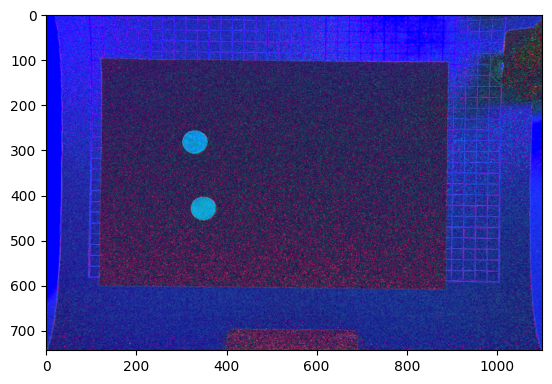

In [10]:
# A compléter
# Conversion de l'image RGB en HSV
img_piece = corrected_images_pieces[1]
img_piece_HSV = cv2.cvtColor(img_piece,cv2.COLOR_RGB2HSV)

# Affichage de l'image HSV
plt.figure()
plt.imshow(img_piece_HSV)
plt.show()

Que signifient les lettres H, S et V dans HSV ? Qu'affichent chacun des canaux de l'image ?

***Réponse :***

Séparez votre image HSV en 3 images niveaux de gris pour chacun des canaux. Affichez-les.

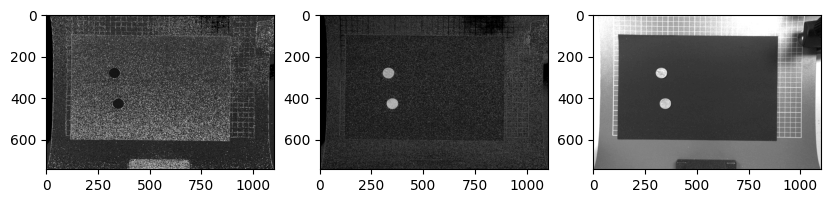

In [11]:
# A compléter
# Séparation de votre image HSV en 3 images niveaux de gris
img_piece_H, img_piece_S, img_piece_V = cv2.split(img_piece_HSV)

# Affichage des canaux de l'image HSV (en niveaux de gris)
plt.figure(figsize=(10,3))
plt.subplot(131)
plt.imshow(img_piece_H,'gray')
plt.subplot(132)
plt.imshow(img_piece_S,'gray')
plt.subplot(133)
plt.imshow(img_piece_V,'gray')
plt.show()

##### B)

Il est l'heure de détecter les cercles ! Pour cela, on va utiliser le canal Saturation de l'image HSV. Appliquez sur cette image un filtre médian avec un kernel de taille 9x9. Affichez le résultat.

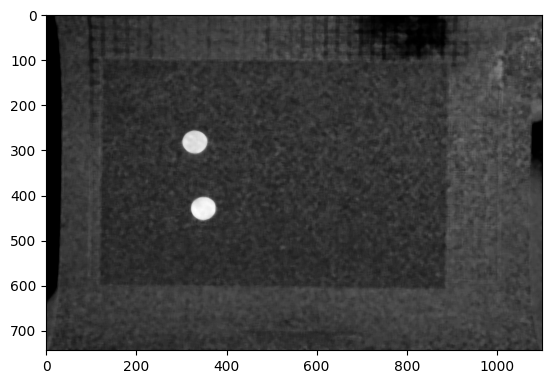

In [21]:
# A compléter
# Application du filtre médian sur l'image Saturation
img_piece_S_med = cv2.medianBlur(img_piece_S,9)

# Affichage du résultat
plt.figure()
plt.imshow(img_piece_S_med,'gray')
plt.show()

Pour détecter les cercles, on va utiliser l'algorithme de Hough. Sans rentrer dans le détail, cet algorithme calcule dans un premier temps la transformée de Hough de l'image, puis va détecter des caractéristiques précises dans cette représentation, correspondant à des cercles sur l'image originale.

Cette transformée de Hough permet également de détecter d'autres caractéristiques précises sur une image, lesquelles ?

***Réponse :***

Avec la fonction HoughCircles d'OpenCV, détectez les cercles sur l'image filtrée précédemment, et affichez le résultat (à savoir votre image originale avec les cercles détectés dessinés par dessus, ainsi que leurs centres). Ajustez les paramètres de la fonction pour détecter uniquement les pièces de monnaie.

Nombre de cercles détectés : 2


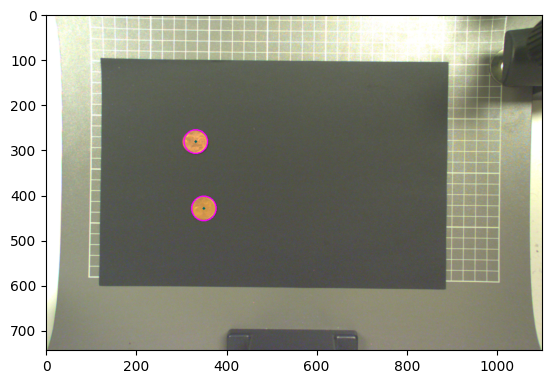

In [22]:
# A compléter
# Détection des cercles via Hough
rows = img_piece_S_med.shape[0]
circles = cv2.HoughCircles(img_piece_S_med, cv2.HOUGH_GRADIENT, 1, rows / 8, 
                          param1=100, param2=30, minRadius=5, maxRadius=50)
if circles is not None:
    print("Nombre de cercles détectés : {}".format(len(circles[0])))
else:
    print("Aucun cercle détecté")
# Affichage des pièces détectées sur l'image originale
output = img_piece.copy()
if circles is not None:
    circles_output = np.uint16(np.around(circles))
    for i in circles_output[0, :]:
        center = (i[0], i[1])
        # circle center
        cv2.circle(output, center, 1, (0, 100, 100), 3)
        # circle outline
        radius = i[2]
        cv2.circle(output, center, radius, (255, 0, 255), 2)

plt.figure()
plt.imshow(output)
plt.show()

Quelles informations avons-nous sur les cercles détectés ? (sortie de la fonction HoughCircles) ?

***Réponse :***

##### C)

Pour chacune des pièces détectées, extrayez le diamètre en pixel, et calculez un diamètre moyen.

In [23]:
# A compléter
# Extraction du diamètre moyen de la pièce (en pixels)
mean_diameter = np.mean(circles[...,2])*2
print("Diamètre moyen (en pixel) : {} px".format(mean_diameter))


Diamètre moyen (en pixel) : 52.5 px


Sachant que la pièce de monnaie a un diamètre précis de 21,25 mm, calculez maintenant la résolution millimètre par pixel de la caméra.

In [24]:
# A compléter
# Calcul de la résolution millimètre par pixel de la caméra
diameter_piece_mm = 21.25
resolution_mm_per_pixel = diameter_piece_mm/mean_diameter
print("Résolution mm par pixel estimée : {}".format(resolution_mm_per_pixel))

Résolution mm par pixel estimée : 0.40476190476190477


Cette valeur dépend-elle uniquement de la caméra ? 

*N'hésitez pas à revoir les formules vues en TD ;)*

***Réponse :***

Pour vérifier que votre valeur est cohérente, reprenez la mesure du diamètre de la pièce en pixel, et à partir des infos que vous avez sur la pièce de monnaie ainsi que la fiche technique de la caméra, calculez la distance de travail (distance entre la caméra et le plan de travail). Cette valeur obtenue correspond-elle à votre installation ?

***Réponse :***

##### D)

Regroupez tout le code écrit précédemment pour faire une fonction d'estimation de la résolution millimètre par pixel de la caméra. La fonction prendra en entrée une image corrigée avec les pièces de monnaie, et retournera les pièces détectées ainsi que la résolution millimètre par pixel estimée. Appliquez-la fonction sur votre image et affichez-les résultats.

In [25]:
# A compléter
# Fonction d'estimation de la résolution millimètre par pixel de la caméra
def resolutionEstimation(img_piece):
    img_piece_HSV = cv2.cvtColor(img_piece,cv2.COLOR_RGB2HSV)
    img_piece_H, img_piece_S, img_piece_V = cv2.split(img_piece_HSV)
    img_piece_S_med = cv2.medianBlur(img_piece_S,9)
    rows = img_piece_S_med.shape[0]
    circles = cv2.HoughCircles(img_piece_S_med, cv2.HOUGH_GRADIENT, 1, rows / 8, 
                              param1=100, param2=30, minRadius=5, maxRadius=50)
    if circles is not None:
        mean_diameter = np.mean(circles[...,2])*2
        diameter_piece_mm = 21.25
        return diameter_piece_mm/mean_diameter
    else:
        return None

# Application de la fonction sur l'image corrigée avec les pièces de monnaie
resolution_mm_per_pixel = resolutionEstimation(corrected_images_pieces[1])
print("Résolution mm par pixel estimée : {}".format(resolution_mm_per_pixel))

Résolution mm par pixel estimée : 0.40476190476190477


---

# 5) Allez, détectons les bonbons !

Voilà, on a tout ce qu'il nous faut maintenant pour détecter et mesurer les bonbons ! Les images sont corrigées, et on a notre valeur de référence.

Ici, on veut détecter les différentes bonbons, mais surtout assurer de leur qualité. Ici, l'industriel considère qu'un bonbon est correct si et seulement si :
- Sa longueur est de 13.7 cm (+/- 10%)
- Sa largeur est de 2.8 cm (+/- 5%)
- Sa couleur (seuls les verts sont acceptés)

ATTENTION : il faut détecter TOUS les bonbons, valides ou non (il faut identifier ceux à jeter !)

La tâche paraît compliquée, mais on va y aller étape par étape.

##### A)

Dans un premier temps, on va détecter les bonbons, avant d'en extraire des caractéristiques. Pour cela, on va ré-utiliser le canal Saturation du format HSV. Convertissez votre image corrigée avec les bonbons en format HSV, extrayez le canal Saturation et affichez-le.

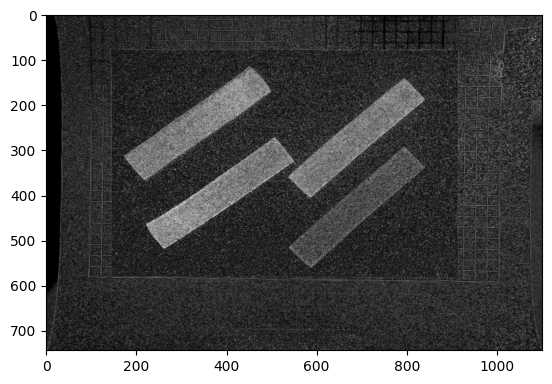

In [54]:
# A compléter
# Conversion de l'image en HSV
img_bonbon = corrected_images_bonbons[9]
img_bonbon_HSV = cv2.cvtColor(img_bonbon,cv2.COLOR_RGB2HSV)

# Extraction du canal Saturation
img_bonbon_H, img_bonbon_S, img_bonbon_V = cv2.split(img_bonbon_HSV)

# Affichage du canal Saturation (en niveaux de gris)
plt.figure()
plt.imshow(img_bonbon_S,'gray')
plt.show()

Ensuite, avant de détecter des contours, il faut binariser l'image. Pour cela, trouvez un seuil optimal permettant de distinguer les bonbons du fond de l'image. Affichez-le résultat.

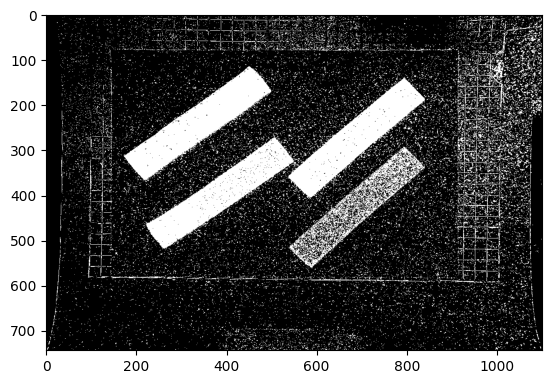

In [55]:
# A compléter
# Binarisation de l'image
_, img_bonbon_S_bin = cv2.threshold(img_bonbon_S,70,255,cv2.THRESH_BINARY)

# Affichage du résultat
plt.figure()
plt.imshow(img_bonbon_S_bin,'gray')
plt.show()

Détectons maintenant les contours avec la fameuse fonction findContours d'OpenCV. Appliquez des règles pour sélectionner uniquement les contours qui vous intéressent et affichez-le résultat (à savoir l'image RGB originale avec les contours détectés).

Nombre de contours détectés : 20484
Nombre de contours filtrés : 4


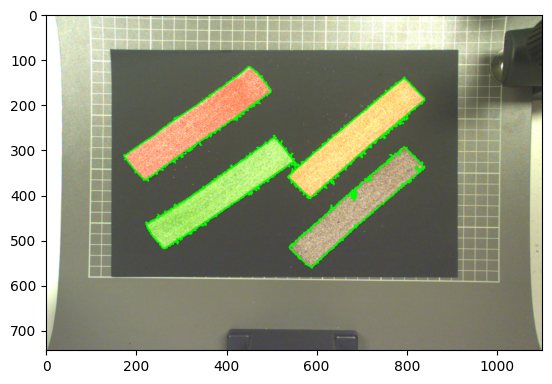

In [28]:
# A compléter
# Détection des contours
contours,_ = cv2.findContours(img_bonbon_S_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print("Nombre de contours détectés : {}".format(len(contours)))

# Filtrage des contours pour garder uniquement ceux qui nous intéressent
contours = [cnt for cnt in contours if cv2.contourArea(cnt)>10000]
print("Nombre de contours filtrés : {}".format(len(contours)))

# Affichage du résultat
output = cv2.drawContours(img_bonbon.copy(),contours, -1, (0,255,0),2)
plt.figure()
plt.imshow(output)
plt.show()

Est-ce que votre résultat est satisfaisant ? Les détections sont-elles correctes ? Sont-elles précises ? Que pouvez-vous améliorer ?

***Réponse :***

Regroupez les dernières cellules codées pour en faire une fonction qui détecte les bonbons depuis une image RGB corrigée. N'hésitez pas à modifier cette chaîne de traitement avec des algorithmes connus pour améliorer la précision de vos résultats.

*Indice : TD3*

In [61]:
# A compléter
# Fonction de détection des bonbons
def detectionBonbons(img_bonbon):
    img_bonbon_HSV = cv2.cvtColor(img_bonbon,cv2.COLOR_RGB2HSV)
    img_bonbon_H, img_bonbon_S, img_bonbon_V = cv2.split(img_bonbon_HSV)
    img_bonbon_S = cv2.medianBlur(img_bonbon_S,9)
    _, img_bonbon_S_bin = cv2.threshold(img_bonbon_S,70,255,cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
    img_bonbon_S_bin = cv2.morphologyEx(cv2.morphologyEx(img_bonbon_S_bin, cv2.MORPH_CLOSE, kernel), cv2.MORPH_OPEN, kernel)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))
    img_bonbon_S_bin = cv2.morphologyEx(cv2.morphologyEx(img_bonbon_S_bin, cv2.MORPH_CLOSE, kernel), cv2.MORPH_OPEN, kernel)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(13,13))
    img_bonbon_S_bin = cv2.morphologyEx(cv2.morphologyEx(img_bonbon_S_bin, cv2.MORPH_CLOSE, kernel), cv2.MORPH_OPEN, kernel)

    contours,_ = cv2.findContours(img_bonbon_S_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [cnt for cnt in contours if cv2.contourArea(cnt)>10000]
    return contours

# Application sur une image
bonbons_detectes = detectionBonbons(img_bonbon)

L'affichage des résultats étant primordial, créez une fonction d'affichage prenant en entrée votre image RGB et les différents contours. Cette fonction affichera cette image avec les contours dessinés. Appliquez la fonction sur l'image RGB avec les contours détectés.

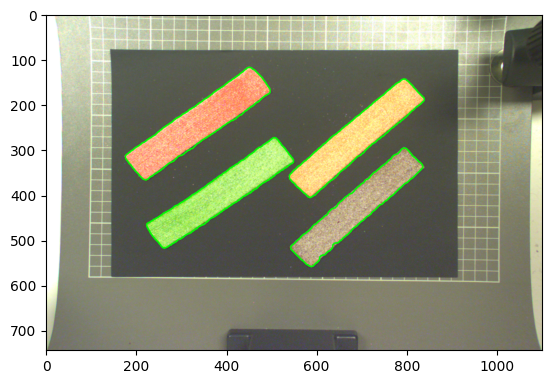

4

In [62]:
# A compléter
# Fonction d'affichage des détections
def affichageBonbons(img,bonbons_detectes):
    output = img.copy()
    output = cv2.drawContours(output, bonbons_detectes, -1, (0,255,0),2)
    plt.figure()
    plt.imshow(output)
    plt.show()

# Application de la fonction sur votre image RGB avec les détections
affichageBonbons(img_bonbon,bonbons_detectes)
len(bonbons_detectes)

##### B)

Les contours sont détectés, mais il faut maintenant mesurer les bonbons ! Si votre détection des contours est correcte, les contours obtenus devraient ressembler à des rectangles. Cependant, ils peuvent comprendre plus de 4 points. On pourrait calculer une approximation des contours pour en sortir un rectangle, mais c'est compliqué pour pas grand chose. On va plutôt calculer le rectangle d'aire minimum du contour (minAreaRect avec OpenCV), qui devrait nous donner un contour assez ressemblant que celui qu'on cherche avec uniquement 4 coordonnées.

Pour chacun des contours détectés, calculez le rectangle d'aire minimum. Affichez les approximations faites (image RGB avec les rectangles dessinés).

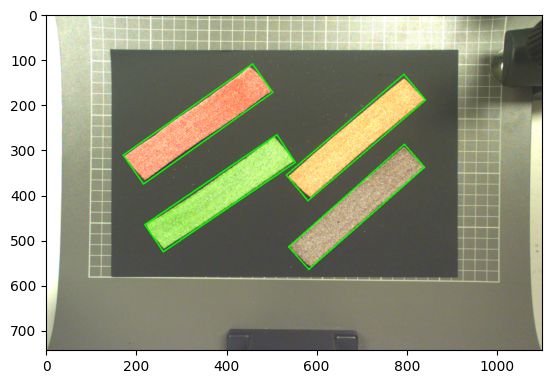

In [63]:
# A compléter
# Calcul des rectangles d'aire minimum des contours
rectangles_detectes = [cv2.minAreaRect(b) for b in bonbons_detectes]

# Affichage des rectangles estimés sur l'image RGB
output = img_bonbon.copy()

for rect in rectangles_detectes:
    box = cv2.boxPoints(rect)
    box = np.intp(box)
    cv2.drawContours(output,[box],0,(0,255,0),2)

plt.figure()
plt.imshow(output)
plt.show()

Quelles informations renvoie la fonction minAreaRect d'OpenCV ? 

***Réponse :***

Extrayez la longueur et la largeur des rectangles en pixels des différentes détections, et convertissez-les en mm avec la valeur de résolution calculée précédemment.

In [64]:
# A compléter
# Calcul des longueurs et largeurs des rectangles en pixels
rectangles_sizes = [r[1] for r in rectangles_detectes]
# Conversion des valeurs en mm
rectangles_sizes_mm = [[r[0]*resolution_mm_per_pixel,r[1]*resolution_mm_per_pixel] for r in rectangles_sizes]

print("Estimation des tailles des bonbons :")
for i,size in enumerate(rectangles_sizes_mm):
    print("Bonbon {} : {:.2f} x {:.2f} cm".format(i+1, size[0]/10, size[1]/10))

Estimation des tailles des bonbons :
Bonbon 1 : 2.73 x 13.87 cm
Bonbon 2 : 2.95 x 14.33 cm
Bonbon 3 : 3.00 x 13.89 cm
Bonbon 4 : 3.13 x 14.22 cm


L'industriel exige que les bonbons aient :
- Une longueur de 13.7 cm (+/- 10%)
- Une largeur de 2.8 cm (+/- 5%)

Reprenez votre fonction de détection des bonbons et d'affichage, et modifiez-les pour calculer les dimensions des rectangles en mm, et classifier la validité du bonbon (Vrai si les dimensions sont correctes, Faux sinon). Affichez ensuite les détections sur image RGB en indiquant la taille estimée (texte à côté des rectangles) et la validité du bonbon (rectangle vert si les dimensions sont correctes, rouge sinon).

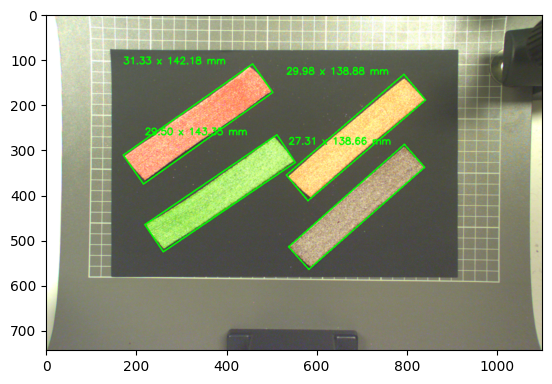

In [101]:
# A compléter
# Fonction de détection et classification des bonbons
def detectionBonbons(img_bonbon):
    img_bonbon_HSV = cv2.cvtColor(img_bonbon,cv2.COLOR_RGB2HSV)
    img_bonbon_H, img_bonbon_S, img_bonbon_V = cv2.split(img_bonbon_HSV)
    img_bonbon_S = cv2.medianBlur(img_bonbon_S,9)
    _, img_bonbon_S_bin = cv2.threshold(img_bonbon_S,70,255,cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
    img_bonbon_S_bin = cv2.morphologyEx(cv2.morphologyEx(img_bonbon_S_bin, cv2.MORPH_CLOSE, kernel), cv2.MORPH_OPEN, kernel)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))
    img_bonbon_S_bin = cv2.morphologyEx(cv2.morphologyEx(img_bonbon_S_bin, cv2.MORPH_CLOSE, kernel), cv2.MORPH_OPEN, kernel)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(13,13))
    img_bonbon_S_bin = cv2.morphologyEx(cv2.morphologyEx(img_bonbon_S_bin, cv2.MORPH_CLOSE, kernel), cv2.MORPH_OPEN, kernel)

    contours,_ = cv2.findContours(img_bonbon_S_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [cnt for cnt in contours if cv2.contourArea(cnt)>10000]

    rectangles_detectes = [cv2.minAreaRect(b) for b in contours]

    # Calcul des longueurs et largeurs des rectangles en pixels
    rectangles_sizes = [r[1] for r in rectangles_detectes]
    
    # Conversion des valeurs en mm
    rectangles_sizes_mm = [[r[0]*resolution_mm_per_pixel,r[1]*resolution_mm_per_pixel] for r in rectangles_sizes] 

    # Validité bonbons
    min_size_bonbon = 28
    max_size_bonbon = 137
    marge_erreur_min_size = 0.15
    marge_erreur_max_size = 0.15

    min_size_rect = [min(r) for r in rectangles_sizes_mm]
    max_size_rect = [max(r) for r in rectangles_sizes_mm]
    
    valid_min_size = [(m < min_size_bonbon*(1+marge_erreur_min_size)) & (m > min_size_bonbon*(1-marge_erreur_min_size)) for m in min_size_rect]
    valid_max_size = [(m < max_size_bonbon*(1+marge_erreur_max_size)) & (m > max_size_bonbon*(1-marge_erreur_max_size)) for m in max_size_rect]
    valid_bonbons = np.logical_and(valid_min_size,valid_max_size)

    return rectangles_detectes, rectangles_sizes_mm, valid_bonbons


# Fonction d'affichage des bonbons, de leur dimension et leur validité (vert ou rouge)
def affichageBonbons(img,bonbons_detectes,bonbon_sizes,valid_bonbons):
    output = img.copy()
    for bonbon,size,valid in zip(bonbons_detectes,bonbon_sizes,valid_bonbons):
        if valid:
            color = (0,255,0)
        else:
            color = (255,0,0)
        box = cv2.boxPoints(bonbon)
        box = np.intp(box)
        cv2.drawContours(output, [box], -1, color,2)
        x = min([b[0] for b in box])
        y = min([b[1] for b in box])
        cv2.putText(output,"{:.2f} x {:.2f} mm".format(size[0],size[1]),(x,y),cv2.FONT_HERSHEY_SIMPLEX,0.7,color,2)

    plt.figure()
    plt.imshow(output)
    plt.show()

# Application et affichage des résultats de détections
bonbons_detectes, bonbons_size, valid_bonbons = detectionBonbons(img_bonbon)
affichageBonbons(img_bonbon,bonbons_detectes,bonbons_size,valid_bonbons)


##### C) 

Pour finir, il faut qu'on garde uniquement les bonbons de couleur verte. Pour cela, on va utiliser l'espace de couleur HSV, comme vu précédemment, et plus précisément le canal Hue. Extrayez le canal Hue de votre image HSV calculée précédemment et affichez-le.

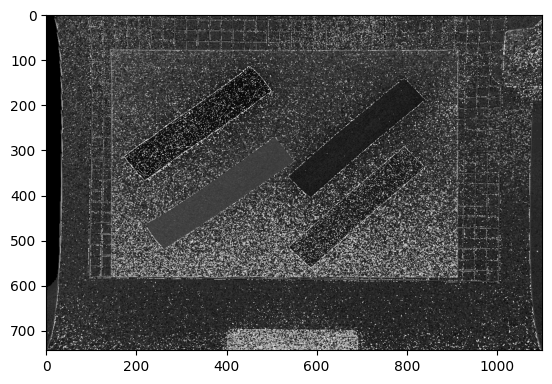

In [66]:
# A compléter
# Extraction du canal Hue
img_bonbon_HSV = cv2.cvtColor(img_bonbon,cv2.COLOR_RGB2HSV)
img_bonbon_H, img_bonbon_S, img_bonbon_V = cv2.split(img_bonbon_HSV)

# Affichage du canal Hue (en niveaux de gris)
plt.figure()
plt.imshow(img_bonbon_H,'gray')
plt.show()

Ce canal encode les teintes de couleur de l'image. Cela veut dire que les teintes rouges auront à peu près les mêmes valeurs, pareil pour les teintes jaunes ou bleues. Pour cela, on utilise une roue des couleurs pour distinguer les teintes.

![alt text](HSVWheel.png)

Les couleurs sont codées entre 0 et 360°. Par exemple, tous les pixels roses auront une teinte entre 290 et 320°. Cependant, pour pouvoir conserver notre image en format uint8 (entiers positifs sur 8 bits), avec une valeur maximum de 255, les valeurs de teintes sont divisées par 2. Pour la teinte rose, la range de valeur passera alors de 145 à 160. Si on re-formule ça, tous les pixels d'une image HSV avec des valeurs entre 145 et 160 sur le canal H auront une teinte rose sur l'image RGB.

Etant donné qu'on souhaite détecter la couleur verte, quelle range de valeur va-t-on détecter sur le canal Hue ?

***Réponse :***

Créez un masque du canal Hue contenant uniquement les pixels verts (Vrai si dans la range de valeur, Faux sinon), et affichez le résultat.

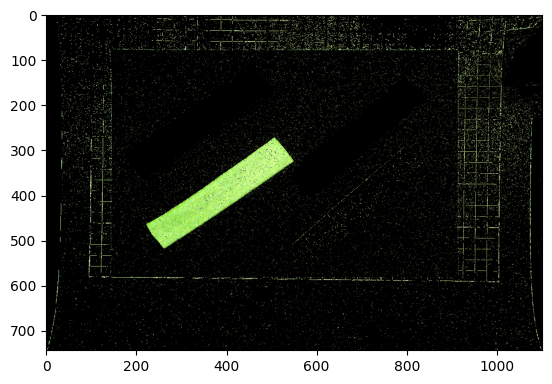

In [81]:
# A compléter
# Création du masque de pixels verts
lower_green = np.array([35,70,70])
upper_green = np.array([85,255,255])

# Threshold the HSV image to get only green colors
mask = cv2.inRange(img_bonbon_HSV, lower_green, upper_green)

# Bitwise-AND mask and original image
res = cv2.bitwise_and(img_bonbon, img_bonbon, mask=mask)

# Affichage du masque
plt.imshow(res,'gray')
plt.show()

Le résultat est-il satisfaisant ?

***Réponse :***

*Note : Il est possible que vous ayez des pixels qui aient une teinte verte alors qu'ils paraissent plutôt noirs ou blancs sur votre image. Ce sont des pixels qui ont des valeurs de Saturation et/ou de Value assez basses. Pour les éliminer, vous pouvez combiner votre masque précédent avec un autre masque qui supprime tous les pixels ayant des valeurs de Saturation ou Value très basses.*

Reprenez vos fonction de détection de contours et d'affichage, et modifiez-les pour intégrer la sélection des pixels verts, et ainsi valider uniquement les bonbons dont les pixels sont majoritairement verts. Pour cela, je vous conseille d'aller voir les propriétés des contours et les fonctions usuelles (https://docs.opencv.org/3.4/d1/d32/tutorial_py_contour_properties.html). Affichez les détections des bonbons, leur dimension, leur couleur (texte "rouge"/"vert" à côté des rectangles) et leur validité (vert si ok, rouge sinon).

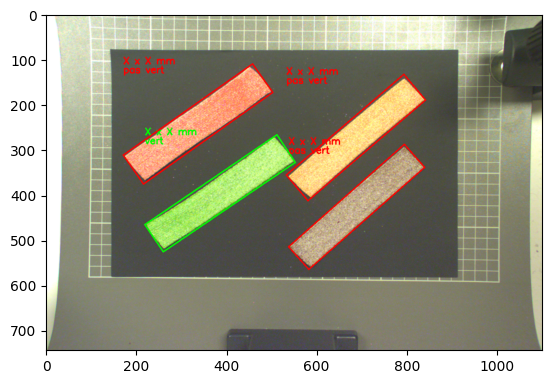

In [103]:
# A compléter
# Fonction de détection et classification des bonbons
def detectionBonbons(img_bonbon):
    img_bonbon_HSV = cv2.cvtColor(img_bonbon,cv2.COLOR_RGB2HSV)
    img_bonbon_H, img_bonbon_S, img_bonbon_V = cv2.split(img_bonbon_HSV)
    img_bonbon_S = cv2.medianBlur(img_bonbon_S,9)
    _, img_bonbon_S_bin = cv2.threshold(img_bonbon_S,70,255,cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
    img_bonbon_S_bin = cv2.morphologyEx(cv2.morphologyEx(img_bonbon_S_bin, cv2.MORPH_CLOSE, kernel), cv2.MORPH_OPEN, kernel)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))
    img_bonbon_S_bin = cv2.morphologyEx(cv2.morphologyEx(img_bonbon_S_bin, cv2.MORPH_CLOSE, kernel), cv2.MORPH_OPEN, kernel)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(13,13))
    img_bonbon_S_bin = cv2.morphologyEx(cv2.morphologyEx(img_bonbon_S_bin, cv2.MORPH_CLOSE, kernel), cv2.MORPH_OPEN, kernel)

    contours,_ = cv2.findContours(img_bonbon_S_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [cnt for cnt in contours if cv2.contourArea(cnt)>10000]

    rectangles_detectes = [cv2.minAreaRect(b) for b in contours]

    # Calcul des longueurs et largeurs des rectangles en pixels
    rectangles_sizes = [r[1] for r in rectangles_detectes]
    
    # Conversion des valeurs en mm
    rectangles_sizes_mm = [[r[0]*resolution_mm_per_pixel,r[1]*resolution_mm_per_pixel] for r in rectangles_sizes] 

    # Validité bonbons
    min_size_bonbon = 28
    max_size_bonbon = 137
    marge_erreur_min_size = 0.1
    marge_erreur_max_size = 0.1

    min_size_rect = [min(r) for r in rectangles_sizes_mm]
    max_size_rect = [max(r) for r in rectangles_sizes_mm]
    
    valid_min_size = [(m < min_size_bonbon*(1+marge_erreur_min_size)) & (m > min_size_bonbon*(1-marge_erreur_min_size)) for m in min_size_rect]
    valid_max_size = [(m < max_size_bonbon*(1+marge_erreur_max_size)) & (m > max_size_bonbon*(1-marge_erreur_max_size)) for m in max_size_rect]
    valid_size_bonbons = np.logical_and(valid_min_size,valid_max_size)

    # Validité couleur

    lower_green = np.array([35,70,70])
    upper_green = np.array([85,255,255])
    # Threshold the HSV image to get only green colors
    green_mask = cv2.inRange(img_bonbon_HSV, lower_green, upper_green)
    
    valid_color_bonbons = []
    for bonbon in contours:
        mask = np.zeros_like(img_bonbon_S)
        mask = cv2.drawContours(mask,[bonbon],0,1,-1)
        pixelpoints = np.logical_and(mask,green_mask)
        pct_pixel_vert = pixelpoints.sum()/mask.sum()
        valid_color_bonbons.append(pct_pixel_vert>0.5)

    valid_bonbons = np.logical_and(valid_color_bonbons,valid_size_bonbons)
    color_text = ["vert" if c else "pas vert" for c in valid_color_bonbons]
    return rectangles_detectes, rectangles_sizes_mm, color_text, valid_bonbons

# Fonction d'affichage des bonbons, de leur dimension, leur couleur et leur validité (vert ou rouge)
def affichageBonbons(img,bonbons_detectes,bonbon_sizes,color_text,valid_bonbons):
    output = img.copy()
    for bonbon,size,valid,clr_txt in zip(bonbons_detectes,bonbon_sizes,valid_bonbons,color_text):
        if valid:
            color = (0,255,0)
        else:
            color = (255,0,0)
        box = cv2.boxPoints(bonbon)
        box = np.intp(box)
        cv2.drawContours(output, [box], -1, color,2)
        x = min([b[0] for b in box])
        y = min([b[1] for b in box])
        cv2.putText(output,"X x X mm".format(size[0],size[1]),(x,y),cv2.FONT_HERSHEY_SIMPLEX,0.7,color,2)
        cv2.putText(output,clr_txt,(x,y+20),cv2.FONT_HERSHEY_SIMPLEX,0.7,color,2)

    plt.figure()
    plt.imshow(output)
    plt.show()

# Application et affichage des résultats de détections
bonbons_detectes, bonbons_size, color_text, valid_bonbons = detectionBonbons(img_bonbon)
affichageBonbons(img_bonbon,bonbons_detectes,bonbons_size,color_text,valid_bonbons)


---

# 6) Avengers, Assemble !!

Pour finir ce TRES LONG TP, regroupez dans une seule cellule tout le code que vous avez écrit dans des belles fonctions commentées.

In [ ]:
# A compléter
# Fonctions développées durant le TP
...

Ensuite, écrivez le code permettant de refaire tout le TP dans la cellule suivante (allant du chargement des images jusqu'à l'affichage des bonbons valides et rejetés). L'objectif est qu'en changeant uniquement les chemins des images, je puisse faire tourner chez moi tout votre code avec mes propres images ! 

In [ ]:
# A compléter
# Code permettant de refaire tout le TP
...